In [1]:
import librosa
import os
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
DATA_PATH="./Vowel_Data/Vowel/"
n_time_sample=33

In [3]:
n_MFCC=13
seed=0

In [4]:
def get_labels(path=DATA_PATH):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

def speech2mfcc(file_path,max_len=n_time_sample):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

def save_data_to_array(path=DATA_PATH, max_len=n_time_sample):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)
        
def get_train_test(split_ratio=0.8,random_state=42):
    labels,indices,_=get_labels(DATA_PATH)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)

In [5]:
save_data_to_array()

Saving vectors to label -'vowel1': 100%|██████████| 40/40 [00:00<00:00, 114.15it/s]


In [21]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
tot_no_MFCC=X_train.shape[1]*X_train.shape[2]
X_train=X_train.reshape((X_train.shape[0],tot_no_MFCC))
X_test=X_test.reshape(X_test.shape[0],tot_no_MFCC)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

model=keras.Sequential()
model.add(Dense(128, activation='tanh', input_shape=(tot_no_MFCC,)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(7, activation='softmax'))

In [22]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 1.9562 - accuracy: 0.1339
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 1.7467 - accuracy: 0.3438
Epoch 3/20
2/2 [==============================] - 0s 5ms/step - loss: 1.6355 - accuracy: 0.4152
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 1.5991 - accuracy: 0.3705
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 1.4908 - accuracy: 0.4911
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 1.3713 - accuracy: 0.6473
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 1.3310 - accuracy: 0.6161
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 1.3488 - accuracy: 0.5714
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 1.2557 - accuracy: 0.6652
Epoch 10/20
2/2 [==============================] - 0s 5ms/step - loss: 1.2073 - accuracy: 0.6250
Epoch 11/20
2/2 [======================

In [8]:
opt_fn=keras.optimizers.Adam()
loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True)
metrics_fn=[
    keras.metrics.Accuracy()#,
    #keras.metrics.AUC()
]
#metrics_fn=['accuracy']
metrics_fn=['AUC']

model.compile(loss=loss_fn,optimizer=opt_fn,metrics=metrics_fn)
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20)

Epoch 1/20
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2/2 [==============================] - 0s 5ms/step - loss: 1.9365 - auc: 0.5551
Epoch 2/20
2/2 [==============================] - 0s 7ms/step - loss: 1.8950 - auc: 0.6996
Epoch 3/20
2/2 [==============================] - 0s 7ms/step - loss: 1.8711 - auc: 0.7262
Epoch 4/20
2/2 [==============================] - 0s 5ms/step - loss: 1.8586 - auc: 0.7395
Epoch 5/20
2/2 [==============================] - 0s 7ms/step - loss: 1.8436 - auc: 0.7627
Epoch 6/20
2/2 [==============================] - 0s 9ms/step - loss: 1.8303 - auc: 0.7792
Epoch 7/20
2/2 [==============================] - 0s 10ms/step - loss: 1.8123 - auc: 0.8010
Epoch 8/20
2/2 [==============================] - 0s 5ms/step - loss: 1.7983 - auc: 0.8098
Epoch 9/20
2/2 [==============================] - 0s 10ms/step - loss: 1.7813 - auc: 0.8218
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 1.7591 - auc: 0.8375
Epoch 

In [24]:
#Vowel
history_dict=history.history
loss_vowel=history_dict['loss']
acc_vowel=history_dict['accuracy']

In [12]:
DATA_PATH="./Word_Data/Word/"

n_time_sample=44


In [13]:
def get_labels(path=DATA_PATH):
    labels=os.listdir(path)
    label_indices=np.arange(0,len(labels))
    return labels, label_indices, to_categorical(label_indices)

def speech2mfcc(file_path,max_len=n_time_sample):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    if (max_len > mfcc.shape[1]): #.shape[1], 1-->column
        pad_width=max_len-mfcc.shape[1]
        mfcc=np.pad(mfcc,pad_width=((0,0),(0,pad_width)),mode='constant')
    else:
        mfcc=mfcc[:,:max_len]
    return mfcc

def save_data_to_array(path=DATA_PATH, max_len=n_time_sample):
    labels,_,_=get_labels(path)

    for label in labels:
        mfcc_vectors=[]

        speechfiles=[path + label + '/' + speech for speech in os.listdir(path+'/'+label)]
        for speech in tqdm(speechfiles,"Saving vectors to label -'{}'".format(label)):
            mfcc=speech2mfcc(speech,max_len=max_len)
            mfcc_vectors.append(mfcc)
            
        np.save(label+'.npy',mfcc_vectors)
        
def get_train_test(split_ratio=0.8,random_state=42):
    labels,indices,_=get_labels(DATA_PATH)

    X=np.load(labels[0]+'.npy')
    y=np.zeros(X.shape[0])

    for i,label in enumerate(labels[1:]):
        x=np.load(label+'.npy')
        X=np.vstack((X,x))
        y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))
    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True)

In [14]:
save_data_to_array()

Saving vectors to label -'Word6': 100%|██████████| 40/40 [00:00<00:00, 114.09it/s]


In [15]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
tot_no_MFCC=X_train.shape[1]*X_train.shape[2]
X_train=X_train.reshape((X_train.shape[0],tot_no_MFCC))
X_test=X_test.reshape(X_test.shape[0],tot_no_MFCC)
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)


model=keras.Sequential()
model.add(Dense(128, activation='tanh', input_shape=(tot_no_MFCC,)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(7, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])
history=model.fit(X_train,y_train_hot,batch_size=128,epochs=20,verbose=1)

Epoch 1/20
2/2 [==============================] - 0s 7ms/step - loss: 1.9368 - accuracy: 0.2009
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 1.8754 - accuracy: 0.3080
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 1.7427 - accuracy: 0.3750
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 1.6365 - accuracy: 0.3884
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 1.6987 - accuracy: 0.4241
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 1.4752 - accuracy: 0.6518
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 1.3696 - accuracy: 0.6607
Epoch 8/20
2/2 [==============================] - 0s 8ms/step - loss: 1.2626 - accuracy: 0.7188
Epoch 9/20
2/2 [==============================] - 0s 8ms/step - loss: 1.2564 - accuracy: 0.6696
Epoch 10/20
2/2 [==============================] - 0s 6ms/step - loss: 1.3212 - accuracy: 0.6161
Epoch 11/20
2/2 [======================

In [17]:
#word
history_dict=history.history
loss_word=history_dict['loss']
acc_word=history_dict['accuracy']

In [18]:
epochs=range(1,len(loss_word)+1)

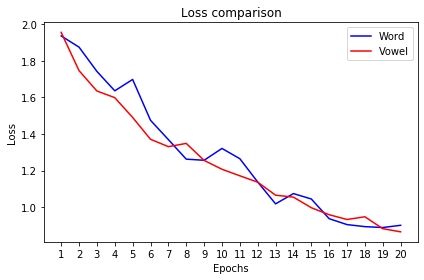

In [25]:
#plt.figure(figsize=(10,4))
plt.plot(epochs,loss_word,'b',label='Word')
plt.plot(epochs,loss_vowel,'r',label='Vowel')
plt.title('Loss comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/loss_compare_diff_len_128_64_32_16_tanh_softmax_rmsprop_batch128'+'.svg',format='svg',dpi=600)

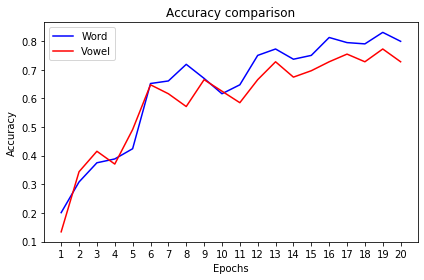

In [26]:
#plt.figure(figsize=(10,4))
plt.plot(epochs,acc_word,'b',label='Word')
plt.plot(epochs,acc_vowel,'r',label='Vowel')
plt.title('Accuracy comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/accuracy_compare_diff_len_128_64_32_16_tanh_softmax_rmsprop_batch128'+'.svg',format='svg',dpi=600)